In [166]:
import numpy as np
import pandas as pd
from tiger.io import read_image, write_image
from tiger.resampling import resample_image, resample_mask
from tiger.patches import PatchExtractor3D
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

## Data exploration - xVertSeg

In [64]:
# 25 images, 15 masks and annotations (img 1-15)
img_paths = [os.path.join('datasets/xvertseg/images', file) for file in sorted(os.listdir('datasets/xvertseg/images'))]
msk_paths = [os.path.join('datasets/xvertseg/masks', file) for file in sorted(os.listdir('datasets/xvertseg/masks'))]
ann = pd.read_excel('datasets/xvertseg/scores.xlsx')
display(ann)

,Spine image,L1 grade,L1 case,L2 grade,L2 case,L3 grade,L3 case,L4 grade,L4 case,L5 grade,L5 case,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,image002,0,0,0,0,0,0,1,1,0,0,NaN,NaN,NaN
1,image008,1,1,1,1,0,0,0,0,0,0,NaN,NaN,NaN
2,image012,0,0,0,0,2,2,0,0,0,0,NaN,NaN,NaN
3,image005,1,2,1,2,0,0,1,1,0,0,NaN,NaN,NaN
4,image015,0,0,0,0,2,1,3,3,0,0,NaN,NaN,NaN
5,image004,0,0,0,0,1,3,1,3,1,1,NaN,NaN,NaN
6,image001,1,3,0,0,1,1,1,1,1,3,NaN,NaN,NaN
7,image006,0,0,2,2,1,2,1,3,0,0,NaN,NaN,NaN
8,image010,2,1,0,0,0,0,1,3,2,2,NaN,NaN,NaN
9,image014,1,1,1,1,1,2,0,0,1,3,NaN,NaN,NaN


In [179]:
imgs = []
msks = []
hdrs = []

# load images with headers and resample to (1,1,1) spacing
for path in img_paths[:2]:
    image, header = read_image(path)
    resampled_img = resample_image(image, header.spacing, [1, 1, 1])  # resample image
    imgs.append(resampled_img)
    
# load masks
for path in msk_paths[:2]:
    mask, header = read_image(path)
    resampled_mask = resample_mask(mask, header.spacing, [1, 1, 1])  # resample mask
    msks.append(resampled_mask)

datasets/xvertseg/images/002.mha
(442, 442, 322)
(442, 442, 322)


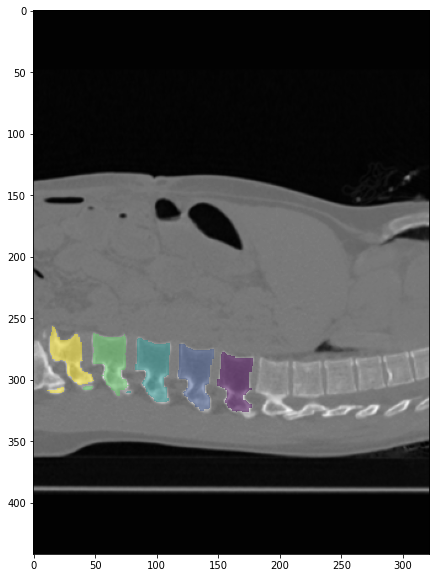

In [180]:
# check and imagine with its mask
i = 1
img = imgs[i]
msk = msks[i] 
plt_msk = np.ma.masked_where(msk == 0, msk)

print(img_paths[i])
print(img.shape)
print(msk.shape)

plt.figure(figsize=(10,10))
plt.imshow(img[200,:,:], cmap='gray')
plt.imshow(plt_msk[200,:,:], alpha=0.5)
plt.plot()
plt.show()

[array([212, 302, 161]), array([213, 297, 128]), array([214, 290,  94]), array([215, 284,  60]), array([217, 281,  27])]


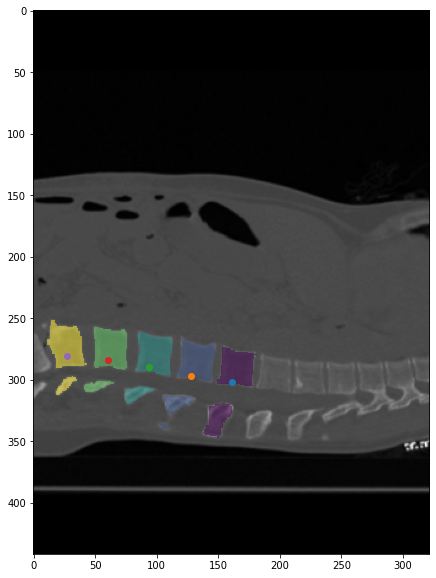

In [182]:
# get labels and centres
labels = np.unique(msk)[1:]
centres = [np.mean(np.argwhere(msk == l), axis=0, dtype=int) for l in labels]
print(centres)

# plot centres
plt.figure(figsize=(10,10))
plt.imshow(img[212,:,:], cmap='gray')
plt.imshow(plt_msk[212,:,:], alpha=0.5)

for c in centres:
    y, x = c[1], c[2]
    plt.scatter(x, y)
plt.show()

In [183]:
# CHECKOUT https://repos.diagnijmegen.nl/doc/tiger/modules/patches.html for extracting patches
# 2d or 3d patches?
patch_size = ()
patch_extracter = PatchExtractor3D(img)

for centre in centres:
    patch = extract_cuboid()